In [1]:
import astropy.units as u
import numpy as np
import popsims
import matplotlib.pyplot as plt
import astropy.coordinates as astro_coord
import glob
import pandas as pd

import itertools
from scipy import stats

from popsims.plot_style import  plot_style
plot_style()

#from shapey import Box
#paths
path_plot ='../figures/'
path_data = '../data/stream/'
isochrone_path='../data/isochrones/'
path_pipeline= '../data/pipeline/'

import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import matplotlib as mpl
from scipy.interpolate import UnivariateSpline
from popsims.plot_tools import plot_annotated_heatmap
from matplotlib import patches

In [2]:
#SOME CONSTANTS

dgrid=np.arange(0.5, 10, 0.2)
BEST_BW=0.9
#dgrid
THEORITICAL_STREAM_WIDTHS={'10_20': 0.053, '30_40': 0.094, '50_60':1.53}
GAP_SIZES={'10_20': 1.4, '30_40': 2.5, '50_60': 1.8}

GAP_PERCENTILE=95
STREAM_PERCENTILE=10

In [3]:
def make_line_plot(ax, x, y, yerr, rgc, show_error=False, **kwargs):
    
    nans=np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(yerr)])
    #print (vls)
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    
    y1 = np.interp(dgrid, x, y) 
    dy1 = np.interp(dgrid, x, y-yerr)
    dy2 = np.interp(dgrid, x, y+yerr)
    
    ax.plot(dgrid, y1, **kwargs)
    
    if show_error:
        ax.fill_between(dgrid, dy1, dy2, alpha=0.1, color=colors[rgc])
    

In [4]:
def get_counts(df, dgrid, rgc, m):
    
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    
    bools=np.logical_and.reduce([(df.bw==BEST_BW).values,\
                                 (df.rgc==rgc).values,
                                 (df.mag_limit==m).values])
    
    bckd=read_backgrounds_file(m, rgc)
    bckd['distance']=10**((bckd.dmod.values/5)+1)
    
    #print (bools)
    df0=(df[bools]).reset_index(drop=True)
    #jkl
    res={'gap_dens':[],
         'stream_dens':[],
         'bck_dens':[],
         'gap_stream_ratio':[],
         'stream_bck_ratio':[],
         'gap_bck_ratio':[],
         'st_error_percent':[],
         'gp_error_percent':[],
         'bck_error_percent':[],
         'gp_snr':[],
         'str_snr':[],
         'gap_spread':[],
         'median_gaploc':[],
         'median_treamloc':[],
         'gp_minus_bck_str_minus_bck':[],
         'gp_minus_bck':[],
         'std_gaploc':[],
         'med_gaploc':[],
         'std_streamloc':[],
         'fr_out_gap':[],
         'fr_stars_out_gap':[],
         'std_gaploc_gapsize_ratio':[],
         'med_gaploc_gapsize_ratio':[],
         'gap_area_over_true_area':[],
         'range_gaploc_gapsize_ratio':[],
         'gp_minus_bck_bck_ratio':[],
         'gp_minus_st_st_ratio':[],
         'ds': dgrid}
    
    for idx in range(len(dgrid)-1):
        v=df0[np.logical_and(df0.distance/1e6>=dgrid[idx], df0.distance/1e6<dgrid[idx+1])]
        
        vbck=bckd[np.logical_and(bckd.distance/1e6>=dgrid[idx], bckd.distance/1e6<dgrid[idx+1])]
        
        st, st_err=  np.nanmedian(v.stream_dens.values),  np.nanstd(v.stream_dens.values)
        gp, gp_err=  np.nanmedian(v.gap_dens.values),  np.nanstd(v.gap_dens.values)
        bck, bck_err=  np.nanmedian(vbck.density.values), np.nanstd(vbck.density.values)
        
        #densities
        res['stream_dens'].append([st, st_err])
        res['gap_dens'].append([gp, gp_err])
        res['bck_dens'].append([bck, bck_err])

        stream_bck_ratio=st/bck
        gap_bck_ratio= gp/bck
        gap_st_ratio= gp/st
        #errors
        stream_bck_ratio_er= ((st_err/st)**2+ (bck_err/bck)**2)**0.5
        gap_bck_ratio_er= ((gp_err/gp)**2+ (bck_err/bck)**2)**0.5
        gap_st_ratio_er= ((gp_err/gp)**2+ (st_err/st)**2)**0.5
        
        res['gap_stream_ratio'].append([gap_st_ratio,gap_st_ratio_er])
        res['gap_bck_ratio'].append([gap_bck_ratio,gap_bck_ratio_er])
        res['stream_bck_ratio'].append([stream_bck_ratio,stream_bck_ratio_er])
        
        res['gp_minus_bck_bck_ratio'].append([(gp-bck)/st, 0])
        res['gp_minus_st_st_ratio'].append([(gp-st)/st, 0])

        
    
        res['st_error_percent'].append([st_err/st, 0.])
        res['gp_error_percent'].append([gp_err/gp, 0])
        res['bck_error_percent'].append([bck_err/bck, 0])
        
        res['gp_minus_bck_str_minus_bck'].append([(gp-bck)/(st-bck), 0])
        res['gp_minus_bck'].append([gp-bck, 0])
        
        
        gap_area= np.nanmedian(v.gap_area.values)
        gap_area_err= np.nanstd(v.gap_area.values)
        
        true_gap_area= GAP_SIZES[rgc]*np.nanmedian(v.spread_stream_stars_y.values)
        res['gap_area_over_true_area'].append([gap_area/true_gap_area,  gap_area_err/true_gap_area])
        cs= v.gap_points.values
    
        csx=[]
        
        if len(cs)>0:
            csx=np.concatenate([x for x in cs if len(x)>0])
    
            diffs=np.abs(csx-rgcx)
            med= np.nanmedian(diffs)
            std=np.nanstd(diffs)
            rang= np.ptp(diffs)
            
            fr= len(diffs[np.abs(diffs>0.5*GAP_SIZES[rgc])])/len(diffs)
            
            res['fr_out_gap'].append([fr, 0])
            res['std_gaploc_gapsize_ratio'].append([std/GAP_SIZES[rgc], 0])
            res['med_gaploc_gapsize_ratio'].append([med/GAP_SIZES[rgc], 0])
            res['range_gaploc_gapsize_ratio'].append([rang//GAP_SIZES[rgc], 0])
            res['std_gaploc'].append([std, 0])
            res['med_gaploc'].append([med, 0])
        else:
            res['fr_out_gap'].append([np.nan, 0])
            res['std_gaploc_gapsize_ratio'].append([np.nan, 0])
            res['med_gaploc_gapsize_ratio'].append([np.nan, 0])
            res['range_gaploc_gapsize_ratio'].append([np.nan, 0])
            res['std_gaploc'].append([np.nan, 0])
            res['med_gaploc'].append([np.nan, 0])
            
        
        cs= v.gap_stars.values
        csx=[]
        if len(cs)>0:
            csx=np.concatenate([x for x in cs if len(x)>0])
    
            diffs=np.abs(csx-rgcx)
            med= np.nanmedian(diffs)
            std=np.nanstd(diffs)
            rang= np.ptp(diffs)
            
            fr= len(diffs[np.abs(diffs>0.5*GAP_SIZES[rgc])])/len(diffs)
            
            res['fr_stars_out_gap'].append([fr, 0])
        else:
            res['fr_stars_out_gap'].append([np.nan, 0])
            

    return res

In [5]:
#functions
def show_gap_detection(vld,  GAP_SIZE, plot='None', ax=None, alpha=0.1, ms=0.1):
        #define stuff 
        meshgrid= vld['meshgrid']
        data=vld['data']
        
        grid_data = np.hstack([ xi.ravel().reshape(-1,1) for xi in meshgrid])
        
        gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'].flatten(),GAP_PERCENTILE ) 
        stream_mask= vld['min_eigen'] < np.percentile(vld['min_eigen'].flatten(),STREAM_PERCENTILE)
        
        #define weights as the density inside the stream
        #weights= 
        
        if np.isnan( vld['min_eigen']).all():
            return {}
        
        stream_size=1.0*np.nanstd(meshgrid[1][stream_mask])

        pol=np.poly1d(np.polyfit(meshgrid[0][stream_mask], meshgrid[1][stream_mask], 2))
        #pol=UnivariateSpline(meshgrid[0][stream_mask], meshgrid[1][stream_mask])


        #define stream track and gap track
        stream_track=np.abs(grid_data[:,1] - pol(grid_data[:,0]))< stream_size/2
        #redefine the stream track as a check (just a random place at 0.5 pc from the center)

        gap_center=(np.nanmedian(meshgrid[0][gap_mask]), np.nanmedian(meshgrid[1][gap_mask]))

        gap_track=np.logical_and.reduce([np.abs((grid_data[:,0]-gap_center[0])) <GAP_SIZE/2,
                                        stream_track])
        #gap_track= np.abs((grid_data[:,0]-gap_center[0])) <GAP_SIZE/2

        #print (data[0])
        
        data_df=pd.DataFrame()
        data_df['x']=data[0]
        data_df['y']=data[1]
        
        grid_df=pd.DataFrame()
        grid_df['x']= grid_data[:,0]
        grid_df['y']= grid_data[:,1]
        
        stream_track_on_data=(np.abs(pol( data_df.x)-data_df.y)<stream_size/2).values
        gap_track_on_data=np.logical_and(np.abs((data_df.x-gap_center[0])) <GAP_SIZE/2,  stream_track_on_data)

        nstars_stream=len( data_df[stream_track_on_data])
        nstars_bck=len( data_df[~stream_track_on_data])
        nstars_gap=len( data_df[gap_track_on_data])

        #verify
        stream_area=10*len( grid_df[stream_track])/len(grid_df)
        bck_area=10*len( grid_df[~stream_track])/len(grid_df)
        gap_area=10*len(grid_df[gap_track])/len(grid_df)
        
         #compute relevant statistics
        gap_offset=5
        try:
            gap_offset=np.nanmedian(np.abs(meshgrid[0][gap_mask]-np.nanmedian(meshgrid[0])))
        except:
            pass
        
        stats={'spread_stream_stars_x': np.nanstd(meshgrid[0][stream_mask]),
               'spread_stream_stars_y': np.nanstd(meshgrid[1][stream_mask]),
              'spread_gap_stars_x': np.nanstd(meshgrid[0][gap_mask]),
            'spread_gap_stars_y':np.nanstd(meshgrid[1][gap_mask]),
               'nstars_gap':  nstars_gap,
               'nstars_stream':  nstars_stream,
               'nstars_bck': nstars_bck,
               'stream_area': stream_area,
               'gap_area': gap_area,
               'bck_area': bck_area,
               'stream_dens':  np.divide(nstars_stream, stream_area),
               'gap_dens': np.divide(nstars_gap, gap_area),
               'bck_dens':np.divide(nstars_bck, bck_area),
               'offset_center':gap_offset,
               'gap_center': np.nanmedian(grid_data[:,0][gap_track]),
               'gap_points':grid_data[:,0][gap_track],
               'stream_center': np.nanmedian(grid_data[:,1][stream_track]),
               'stream_points':grid_data[:,1][stream_track],
               'stream_stars':data[1][stream_track_on_data],
               'gap_stars':data[0][gap_track_on_data],
              }

        if plot=='show_mask_data':
            ax.scatter(data_df.x, data_df.y,  s=ms, alpha=alpha, c='k')
            ax.scatter(data_df.x[stream_track_on_data], data_df.y[stream_track_on_data],  s=10, alpha=0.1, c='r', label='Stream')
            ax.scatter(data_df.x[gap_track_on_data], data_df.y[gap_track_on_data],  s=10, alpha=0.1, c='b', label='Gap')
        
        if plot=='show_mask_grid':
            ax.scatter(grid_df.x, grid_df.y,  s=ms, alpha=alpha, c='k')
            ax.scatter(grid_df.x[stream_track], grid_df.y[stream_track],  s=10, alpha=1, c='r', label='Stream')
            ax.scatter(grid_df.x[gap_track], grid_df.y[gap_track],  s=10, alpha=1, c='b', label='Gap')
            #ax.scatter(grid_df.x[stream_track], grid_df.y,  s=10, alpha=0.1, c='b', label='Bckgd')
            
        if plot=='show_gap_points':
            #ax.scatter(grid_df.x, grid_df.y,  s=ms, alpha=alpha, c='k')
            #ax.scatter(grid_df.x[stream_track], grid_df.y[stream_track],  s=10, alpha=1, c='r', label='Stream')
            ax.scatter(grid_data[:,0][gap_track],grid_data[:,1][gap_track],  s=ms, alpha=alpha, c='#01FF70', marker='*')
            #ax.scatter(grid_df.x[stream_track], grid_df.y,  s=10, alpha=0.1, c='b', label='Bckgd')
        
        if plot=='plot0':
            #verify by plotting
            ax.scatter(vld['data'][0], vld['data'][1],s=10, alpha=alpha, c='k')
            
        if plot=='plot1':

            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=1)
            #ax.scatter(grid_data[:,0], grid_data[:,1], c=res['max_eigen'].flatten(),
            #           s=1, cmap='cubehelix')

        if plot=='plot2':

            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['min_eigen'],  20, \
                              cmap='cubehelix', alpha=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            
        if plot=='plot6':
            #ax.scatter(vld['data'][:,0], vld['data'][:,1],s=0.1, alpha=0.5, c='k')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=alpha, vmin=0, vmax=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                            cmap='Greys', alpha=.1, vmin=0.0, vmax=0.2, linestyle='--')
            
            
            
        if plot=='plot4':
            #verify by plotting
            #ax.scatter(vld['data'][0], vld['data'][1],s=ms, alpha=alpha,  c='#FFFFFF')
            ax.scatter(meshgrid[0][stream_mask], meshgrid[1][stream_mask], marker='*', s=15,c='#FF851B')
            ax.scatter(meshgrid[0][gap_mask], meshgrid[1][gap_mask], marker='*', s=15,  c='#0074D9')
            
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#FF851B', linewidth=3)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][0]), np.max(vld['data'][0])],\
                   ylim=[np.min(vld['data'][1]), np.max(vld['data'][1])])

        if plot=='plot3':
            #verify by plotting
            #ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=alpha, c='k')
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][0]), np.max(vld['data'][0])],\
                   ylim=[np.min(vld['data'][1]), np.max(vld['data'][1])])
            
        if plot=='plot7':
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')
            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3, alpha=alpha)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3, alpha=alpha)

            #plot gap track
            ax.scatter(np.nanmedian(grid_data[:,0][gap_track]), \
                       np.nanmax(vld['meshgrid'][1])-0.5, color='k', marker='$\u2193$', s=100)
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][0]), np.max(vld['data'][0])],\
                   ylim=[np.min(vld['data'][1]), np.max(vld['data'][1])])
            
            
            
        if plot=='plot5':
            #verify by plotting
            ax.scatter(vld['data'][0], vld['data'][1], s=10, alpha=0.2, c='k')
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, cmap='magma_r', alpha=0.5)

            #plot stream track
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#0074D9', linewidth=3)
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#0074D9', linewidth=3)

            #plot gap track
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][0]), np.max(vld['data'][0])],\
                   ylim=[np.min(vld['data'][1]), np.max(vld['data'][1])])
            
            
        if plot=='density':
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')
            p= ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=alpha*3, linestyle='--')

       
        return stats


In [6]:
def get_pipeline_results_full(dmod, mag_limit, rgc, bwu=BEST_BW):
    fls=glob.glob('../data/pipeline/pipeline_rgc{}_mhalo5.00e+06_maglimit{:.2f}_run*.npy'.format(rgc, mag_limit))
    #print (fls
    res=[]
    for f in fls:
        c=np.load(f, allow_pickle=True)
        for vls in c:
            for k in vls.keys():
                bw=(k.split('dmod_galaxy')[0]).split('bw')[-1]
                dmodx=float(k.split('dmod_galaxy')[-1])
                #print (bw)
                if (dmod ==dmodx) and (float(bw)==bwu):
                    res.append(vls[k])
                else:
                    continue
    return res

In [7]:
df = pd.DataFrame()
for f in tqdm(glob.glob('../data/pipeline/*.npy')):
    vlsx=np.load(f, allow_pickle=True)
    for vls in vlsx:
        for k in vls.keys():
            #for i in range(0, 10):
            rgc=f.split('rgc')[-1].split('_mhalo')[0]
            r=pd.Series(show_gap_detection(vls[k],  GAP_SIZES[rgc]))#, ax=ax, plot='plot3'))

            r['rgc']=rgc
            r['run']=f.split('_')[-1].split('.npy')[0]
            r['mag_limit']=float(f.split('_')[-2].split('maglimit')[1])
            r['bw']=float((k.split('dmod_galaxy')[0]).split('bw')[-1])
            r['dmod']=float(k.split('dmod_galaxy')[-1])
            #r['trial']=i


            df=df.append(r, ignore_index=True )

100%|█████████████████████████████████████████████| 2/2 [00:27<00:00, 13.84s/it]


In [8]:
bws=np.unique(df.bw)



In [9]:
bws

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4])

In [10]:
np.unique(df.dmod)

array([23.49, 23.89, 24.23, 24.52, 24.77, 25.  , 25.21, 25.4 , 25.57,
       25.73, 25.88, 26.02, 26.15, 26.28, 26.39, 26.51, 26.61, 26.71,
       26.81, 26.9 , 26.99, 27.07, 27.16, 27.24, 27.31, 27.39, 27.46,
       27.53, 27.59, 27.66, 27.72, 27.78, 27.84, 27.9 , 27.96, 28.01,
       28.06, 28.12, 28.17, 28.22, 28.27, 28.31, 28.36, 28.41, 28.45,
       28.49, 28.54, 28.58, 28.62, 28.66, 28.7 , 28.74, 28.78, 28.82,
       28.85, 28.89, 28.93, 28.96, 29.  , 29.03, 29.06, 29.1 , 29.13,
       29.16, 29.19, 29.23, 29.26, 29.29, 29.32, 29.35, 29.38, 29.4 ,
       29.43, 29.46, 29.49, 29.52, 29.54, 29.57, 29.6 , 29.62, 29.65,
       29.67, 29.7 , 29.72, 29.75, 29.77, 29.8 , 29.82, 29.84, 29.87,
       29.89, 29.91, 29.93, 29.96, 29.98])

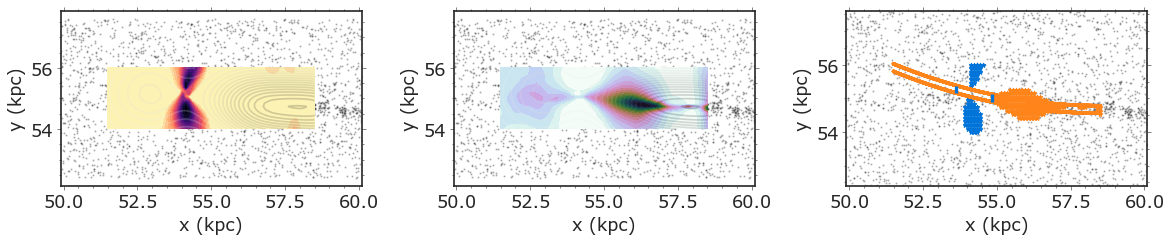

In [18]:
fig, (ax, ax2, ax1)=plt.subplots(ncols=3, figsize=(10*1.5, 2.25*1.5))
bw=0.8
res=get_pipeline_results_full( 25.57, 27.15, '50_60', bwu=bw)[0]
dt=res['data']
ax.scatter(dt[0], dt[1], s=1, alpha=0.2, c='k')
_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot1', ax=ax, alpha=0.3)

ax1.scatter(dt[0], dt[1], s=1, alpha=0.2, c='k')
_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot4', ax=ax1, ms=10, alpha=0.3)

ax2.scatter(dt[0], dt[1], s=1, alpha=0.2, c='k')
_= show_gap_detection(res,  GAP_SIZES['10_20'], plot='plot2', ax=ax2, alpha=0.5)

for a in [ax, ax1, ax2]:
    a.set(xlim=[dt[0].min(), dt[0].max()], xlabel='x (kpc)', ylabel='y (kpc)')
    a.minorticks_on()
    
#ax.set(title='Max PiHPi')
#ax2.set(title='Min PiHPi')
plt.tight_layout()
#plt.savefig('../figures/including_more_data_example.jpeg')
plt.savefig('../figures/stream_cutout.jpeg', bbox_inches='tight')

In [19]:
df['rgcx']=df.rgc.apply(lambda x: np.nanmedian(np.array(x.split('_')).astype(float)))

In [27]:
df0=df#[np.logical_and(df.mag_limit==27.15)]
#df0

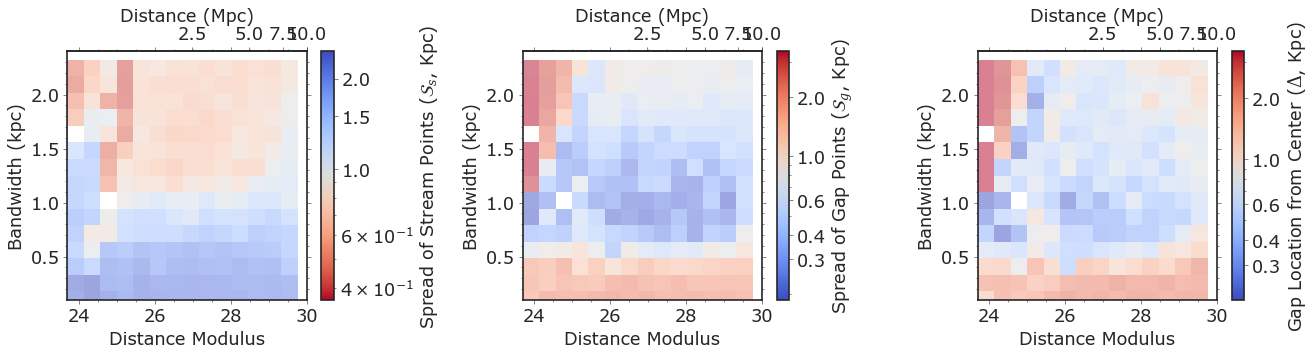

In [29]:
fig, ax=plt.subplots(ncols=3, figsize=(14*1.2, 4*1.2))

#ax[0].scatter(  df.dmod, df.bw, c=df.spread_gap_stars , s=0.1, cmap='cubehelix')
#ax[1].scatter(df.dmod, df.bw, c=df.spread_stream_stars, s=0.1, cmap='cubehelix')

cmap0 = mpl.cm.coolwarm_r
norm0 =mpl.colors.LogNorm()

cmap = mpl.cm.coolwarm
norm1 =mpl.colors.LogNorm()#mpl.colors.CenteredNorm(vcenter=0.05)
norm2 =mpl.colors.LogNorm()#CenteredNorm(vcenter=0.5)

plot_annotated_heatmap(ax[0], df0, 16, ['dmod', 'bw', 'spread_stream_stars_x'],  norm=norm0,cmap=cmap0,annotate=True,  alpha=0.5)
plot_annotated_heatmap(ax[1], df0, 16, ['dmod', 'bw', 'spread_gap_stars_x'], norm=norm1,  cmap=cmap,annotate=False, alpha=0.5)
plot_annotated_heatmap(ax[-1], df0, 16, ['dmod', 'bw', 'offset_center'],  norm=norm2, cmap=cmap,annotate=False, alpha=0.5)

#ax[0].scatter(df.dmod, df.bw, s=.1)

xticks=[1., 1.5,  2.]
cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm0, cmap=cmap0), ax=ax[0], orientation='vertical', label=r'Spread of Stream Points ($\mathcal{S}_s$, Kpc)')
cbar.ax.set(yticks=xticks, yticklabels=xticks)


xticks=[0.3, 0.4, 0.6, 1., 2.]
cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm1, cmap=cmap), ax=ax[1], orientation='vertical', label=r'Spread of Gap Points ($\mathcal{S}_g$, Kpc)')
cbar.ax.set(yticks=xticks, yticklabels=xticks)

cbar=plt.colorbar(mpl.cm.ScalarMappable(norm=norm2, cmap=cmap), ax=ax[-1], orientation='vertical', label=r'Gap Location from Center ($\Delta$, Kpc)')
cbar.ax.set(yticks=xticks, yticklabels=xticks)

def forward(x):
    return (10**((x/5)+1))/1e6

def inverse(x):
    return  5*np.log10(x*1000/(10))

for a in ax:
    secax = a.secondary_xaxis('top', functions=(forward, inverse))
    secax.set(xlabel='Distance (Mpc)')
    
    a.set( xlabel='Distance Modulus', ylabel='Bandwidth (kpc)', ylim=[0.1, 2.4], xlim=[23.7, 30.])


plt.tight_layout()


#actually make 3 stacks, get rid of first panel to emphasize that best bw doesn't depend on gap size
plt.savefig('../figures/gaps_spread_all_bws.pdf', bbox_inches='tight')


In [30]:
dmods=np.unique(df.dmod)